In [1]:
# import de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# configure matplotlib
%config InlineBackend.rc = {}
plt.style.use(['dark_background'])
plt.rcParams.update({'figure.max_open_warning': 0}) 
#plt.rcParams['figure.constrained_layout.use'] = True
plt.close('all')
%matplotlib inline


In [2]:
# import astropy et autre affiliated libs
import astropy.units as u
from astropy.io import fits
from astropy.nddata import StdDevUncertainty
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time
from astropy.modeling import models

from specutils import Spectrum
from specutils.fitting import fit_generic_continuum, fit_continuum
from specutils.analysis import centroid, fwhm, snr, snr_derived
from specutils.spectra import SpectralRegion
from specutils.manipulation import extract_region


In [7]:
# Charger le spectre
spec_name = "../../CAPTURES/20251102_cxdra_v1770cyg_deneb/_v1770cyg_20251102_906.fits"
spec = Spectrum.read(spec_name)

# estime le bruit dans une zone sans raies
mask = (spec.spectral_axis > 6000*u.AA) & (spec.spectral_axis < 6100*u.AA)
noise = np.std(spec.flux[mask].value)

# Ajoute l'incertitude
spec = Spectrum(spectral_axis = spec.spectral_axis,
                  flux = spec.flux,
                  uncertainty = StdDevUncertainty(np.ones_like(spec.flux.value)*noise))

snr_fixe = snr(spec, SpectralRegion(6000*u.AA, 6100*u.AA))
print(f"{snr_fixe=}")
print(f"{spec}")


snr_fixe=<Quantity 76.20451>
Spectrum (length=6346)
Flux=[1.4923062  1.4909269  1.5563143  ... 0.7341747  0.7197913
      0.71099675] ,  mean=1.38423
Spectral Axis=[3700.26563327 3700.84071809 3701.41580291 ... 7348.02862153
               7348.60370635 7349.17879116] Angstrom,  mean=5524.72221 Angstrom
Uncertainty=StdDevUncertainty ([0.01312258 0.01312258 0.01312258 ... 0.01312258 0.01312258 0.01312258] )


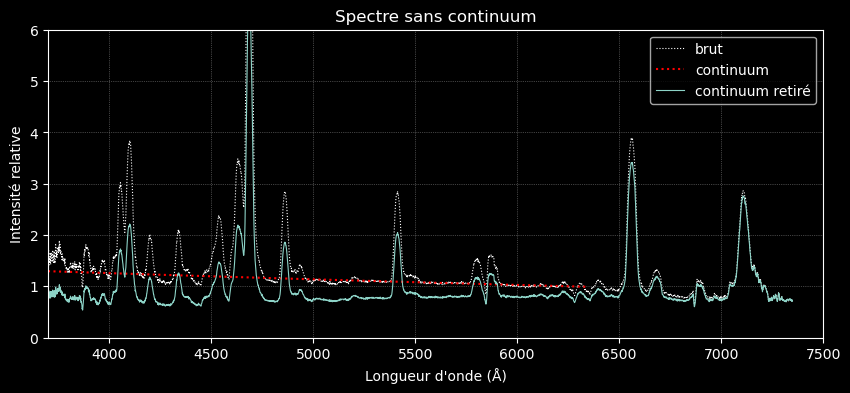

In [9]:
# suppression du continuum
_fit = fit_continuum(spec, model=models.Polynomial1D(degree=2))
continuum = _fit(spec.spectral_axis)
spec_norm = spec / continuum

plt.figure(figsize=(10,4))
plt.plot(spec.spectral_axis, spec.flux, lw=0.8, ls=':', color='white', label='brut')
plt.plot(continuum , color='red', ls=':', label='continuum') #.spectral_axis, cont.flux, color='red')
plt.plot(spec_norm.spectral_axis, spec_norm.flux, lw=0.8, label='continuum retiré')
plt.xlabel("Longueur d'onde (Å)")
plt.ylabel("Intensité relative")
plt.title("Spectre sans continuum")
plt.xlim(3700, 7500)
plt.ylim(0, 6)
plt.legend()
plt.grid(color='grey', linestyle=':', linewidth=0.5)
plt.show()


In [10]:
lines_ref = pd.DataFrame({
    "elem": [
            "N IV", 
            "He II", 
            "N III", 
            "He II",
            "He II",
            "He II", 
            "C IV", 
            "He I",
            "He II/Hα", 
            "N IV",
    ],

    "lambda_rest": [
            4058.0, 
            4340.0, 
            4640.0, 
            4686.0,
            4859.0,
            5411.0, 
            5800.6, 
            5875.6,
            6562.8, 
            7109.0, 
    ]
})


In [11]:
# Coordonnées de la cible
coord = SkyCoord.from_name("V1770 Cyg")

# Localisation du CALC
location = EarthLocation.from_geodetic(lon=-1.68*u.deg, lat=48.11*u.deg, height=50*u.m)

# Date d'observation depuis le header FITS
hdr = fits.getheader(spec_name)
date_obs = Time(hdr["DATE-OBS"], format="isot", scale="utc")
print(f"{date_obs=}")

# Correction barycentrique
corr = coord.radial_velocity_correction(obstime=date_obs, location=location).to(u.km/u.s)
print("Correction barycentrique :", corr)


date_obs=<Time object: scale='utc' format='isot' value=2025-11-02T21:44:08.321>
Correction barycentrique : -16.706377633676038 km / s


In [12]:
from specutils.spectra import SpectralRegion
from specutils.manipulation import extract_region
from specutils.analysis import centroid, fwhm, snr_derived
import numpy as np
import pandas as pd
import astropy.units as u

# DADOS 200 : R ~ 1350 → Δλ ~ 4.6 Å → Δv ~ 100 km/s

"""
sigma_min = FWHM_neon / (SNR * sqrt (N_néon))
Dispersion ≈ 0.575 Å/pixel
N_néon ≈ 8 pixels
FWHM_neon = 4.6 A
--> sigma_min = 4.6 / (130 * sqrt(8)) = 0.16 A
R = lam_rest / FWHM_neon
"""
sigma_min = 2 * u.AA  # incertitude plancher pour DADOS 200 
c_kms = 299792.458 * u.km / u.s
region_width = 25

# Dispersion spectrale
dispersion = (spec_norm.wavelength[1] - spec_norm.wavelength[0]).to(u.AA)

# SNR fixe mesuré dans une zone sans raie
zone_sans_raie = SpectralRegion(6000 * u.AA, 6100 * u.AA)
snr_fixe = snr_derived(extract_region(spec_norm, zone_sans_raie))

print (f"{dispersion=}", f"{snr_fixe=}")

results = []
for _, row in lines_ref.iterrows():
    lam_rest = row["lambda_rest"] * u.AA
    elem = row["elem"]
    region = SpectralRegion(lam_rest - region_width * u.AA, lam_rest + region_width * u.AA)
    subspec = extract_region(spec_norm, region)

    # Mesures
    cen = centroid(subspec)
    width = fwhm(subspec)
    R = lam_rest / width

    # Incertitudes fixées à sigma_min
    cen_err = sigma_min
    width_err = sigma_min

    # Vitesses
    v = (c_kms * (cen - lam_rest) / lam_rest).to(u.km/u.s)
    v_err = (c_kms * cen_err / lam_rest).to(u.km/u.s)
    v_fwhm = (c_kms * width / lam_rest).to(u.km/u.s)
    v_fwhm_err = (c_kms * width_err / lam_rest).to(u.km/u.s)

    # Résolution limite instrumentale
    fwhm_instr = 4.6 * u.AA
    v_res_limit = (c_kms * fwhm_instr / lam_rest).to(u.km/u.s)

    results.append({
        "Élément": elem,
        "λ_rest (Å)": lam_rest.value,
        "λ_obs (Å)": f"{cen.value:.2f} ± {cen_err.value:.0f}",
        #"v_rad (km/s)": f"{v.value:.0f} ± {v_err.value:.0f}",
        "FWHM (Å)": f"{width.value:.2f} ± {width_err.value:.0f}",
        "V expansion (km/s)": f"{v_fwhm.value/2:.0f} ± {v_fwhm_err.value:.0f}",
        #"R": f"{R.value:.0f}",
        #"SNR fixe": f"{snr_fixe:.1f}",
        #"Résolution limite (km/s)": f"{v_res_limit.value:.0f}"
    })

df = pd.DataFrame(results)
df


dispersion=<Quantity 0.57508482 Angstrom> snr_fixe=<Quantity 145.88701346>


,Élément,λ_rest (Å),λ_obs (Å),FWHM (Å),V expansion (km/s)
0,N IV,4058.0,4058.42 ± 2,49.46 ± 2,1827 ± 148
1,He II,4340.0,4340.07 ± 2,49.46 ± 2,1708 ± 138
2,N III,4640.0,4639.50 ± 2,49.46 ± 2,1598 ± 129
3,He II,4686.0,4686.37 ± 2,34.78 ± 2,1112 ± 128
4,He II,4859.0,4860.09 ± 2,44.65 ± 2,1377 ± 123
5,He II,5411.0,5411.92 ± 2,46.16 ± 2,1279 ± 111
6,C IV,5800.6,5800.88 ± 2,49.46 ± 2,1278 ± 103
7,He I,5875.6,5875.70 ± 2,49.46 ± 2,1262 ± 102
8,He II/Hα,6562.8,6562.61 ± 2,49.46 ± 2,1130 ± 91
9,N IV,7109.0,7109.30 ± 2,49.46 ± 2,1043 ± 84


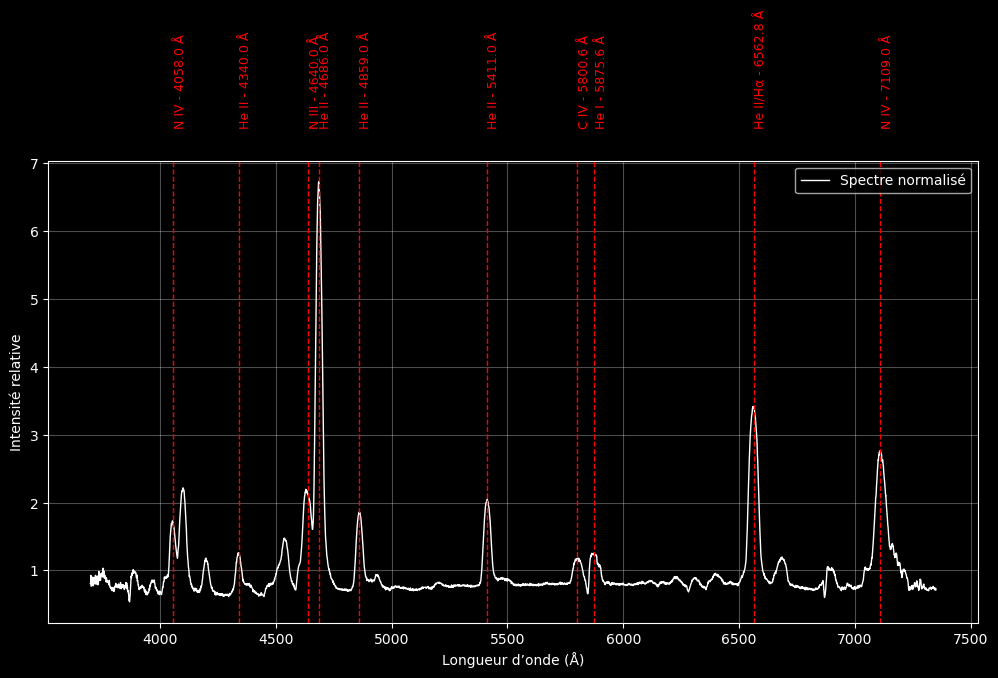

In [13]:
plt.figure(figsize=(12,6))
plt.plot(spec_norm.spectral_axis.to(u.AA).value, spec_norm.flux.value, color='white', lw=1, label="Spectre normalisé")

# Ajout des raies de lines_ref
for _, row in lines_ref.iterrows():
    lam = row["lambda_rest"]
    elem = row["elem"]
    plt.axvline(lam, color='red', ls='--', alpha=1, lw=1)
    plt.text(lam + 2, 7.5, f"{elem} - {lam:.1f} Å", rotation=90, va='bottom', ha='left', fontsize=9, color='red')

# Mise en forme
plt.xlabel("Longueur d’onde (Å)")
plt.ylabel("Intensité relative")
#plt.title("V1770 Cyg normalisé")
#plt.ylim(0, 8)
plt.grid(True, alpha=0.3)
#plt.tight_layout()
plt.legend()
plt.show()


In [17]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from specutils.spectra import SpectralRegion
from specutils.manipulation import extract_region
from specutils.analysis import centroid, fwhm
from specutils.fitting import fit_lines
from astropy.modeling import models

# Liste des raies disponibles
options = [f"{row['elem']} {row['lambda_rest']:.1f} Å" for _, row in lines_ref.iterrows()]
dropdown = widgets.Dropdown(
    options=options,
    description='Raie :',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

output = widgets.Output()

def afficher_profil(change):
    output.clear_output()
    with output:
        # Extraire la raie sélectionnée
        idx = options.index(change['new'])
        row = lines_ref.iloc[idx]
        lam_rest = row["lambda_rest"] * u.AA
        elem = row["elem"]

        # Extraire la région spectrale
        region = SpectralRegion(lam_rest - region_width * u.AA, lam_rest + 20 * u.AA)
        subspec = extract_region(spec_norm, region)

        # Données
        lam = subspec.wavelength.to(u.AA).value
        flux = subspec.flux.value
        lam0 = lam_rest.value
        c_kms = 299792.458  # km/s

        # Conversion en vitesses radiales
        v = c_kms * (lam - lam0) / lam0

        # Mesures
        cen = centroid(subspec).to(u.AA).value
        width = fwhm(subspec).to(u.AA).value
        fwhm_left = cen - width / 2
        fwhm_right = cen + width / 2
        v_cen = c_kms * (cen - lam0) / lam0
        v_left = c_kms * (fwhm_left - lam0) / lam0
        v_right = c_kms * (fwhm_right - lam0) / lam0

        # Ajustement gaussien
        g_init = models.Gaussian1D(amplitude=np.max(flux), mean=cen, stddev=width / (2 * np.sqrt(2 * np.log(2))))
        g_fit = fit_lines(subspec, g_init)
        flux_fit = g_fit(subspec.wavelength.to(u.AA)).value

        # RMS
        rms = np.sqrt(np.mean((flux - flux_fit)**2))

        # Affichage
        print(f"Raie : {elem} {lam_rest:.1f}")
        print(f"Centroïde : {cen:.2f} Å") #Å → {v_cen:.1f} km/s")
        print(f"FWHM : {width:.2f} Å → {(v_right - v_left)/2:.1f} km/s")
        print(f"Écart RMS : {rms:.4f}")

        # Tracé avec double abscisse
        fig, ax1 = plt.subplots(figsize=(8, 4))
        ax1.plot(lam, flux, label='Brut', color='blue')
        ax1.plot(lam, flux_fit, label='Gaussienne', color='orange', linestyle='--')
        ax1.axvline(cen, color='red', linestyle='--') #, label='Centroïde')
        ax1.axvline(lam0, color='green', linestyle='--') #, label='Centroïde')
        ax1.axvline(fwhm_left, color='green', linestyle=':') #, label='FWHM gauche')
        ax1.axvline(fwhm_right, color='green', linestyle=':') #, label='FWHM droite')
        ax1.set_xlabel("Longueur d'onde (Å)")
        ax1.set_ylabel("Intensité relative")
        #ax1.grid(True)

        # Axe secondaire en vitesse
        def wavelength_to_velocity(x):
            return c_kms * (x - lam0) / lam0
        def velocity_to_wavelength(v):
            return lam0 * (1 + v / c_kms)

        ax2 = ax1.twiny()
        ax2.set_xlim(ax1.get_xlim())
        ticks = ax1.get_xticks()
        ax2.set_xticks(ticks)
        ax2.set_xticklabels([f"{wavelength_to_velocity(tick):.0f}" for tick in ticks])
        ax2.set_xlabel("Vitesse (km/s)")

        #fig.suptitle(f"Profil spectral : {elem} {lam_rest.value:.1f} Å")
        ax1.legend(loc='upper right')
        plt.show()

# Lier le dropdown à la fonction
dropdown.observe(afficher_profil, names='value')

display(dropdown, output)
afficher_profil({'new': dropdown.value})  # Affichage automatique de la première raie


Dropdown(description='Raie :', layout=Layout(width='50%'), options=('N IV 4058.0 Å', 'He II 4340.0 Å', 'N III …

Output()

In [165]:
#v_cen = c_kms * (cen - lam0) / lam0
v_cen = c_kms * (6562 - 6560) / 6560
v_cen



<Quantity 91.40013963 km / s>